# Simple Moving Average Crossover Strategy
This is a common strategy. The key idea is as follow:
- Maintain two periods for moving average- a fast moving average, which is short term, and a slow moving average, which is long term.
- Signals: When the fast moving average crosses above the slow moving average, buy. Vice versa for sell. The intuition is that when the fast moving average crosses above the slow moving average, this suggests that upwards momentum is building.

In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 10)

In [3]:
def fetch_btc_data(days=365, timeframe='1d'):
    """
    Fetch BTC/USDT OHLCV data from Binance
    
    Parameters:
    days (int): Number of days of historical data
    timeframe (str): Timeframe ('1d', '4h', '1h', etc.)
    
    Returns:
    pandas.DataFrame: OHLCV data
    """
    try:
        # Initialize Binance exchange
        exchange = ccxt.binance()
        
        # Calculate the number of candles needed
        if timeframe == '1d':
            limit = min(days, 1000)  # Binance limit
        elif timeframe == '4h':
            limit = min(days * 6, 1000)
        elif timeframe == '1h':
            limit = min(days * 24, 1000)
        else:
            limit = 1000
        
        # Fetch OHLCV data
        ohlcv = exchange.fetch_ohlcv('BTC/USDT', timeframe, limit=limit)
        
        # Convert to DataFrame
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        
        # Convert timestamp to datetime
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('datetime', inplace=True)
        df.drop('timestamp', axis=1, inplace=True)
        
        # Convert to float
        for col in ['open', 'high', 'low', 'close', 'volume']:
            df[col] = df[col].astype(float)
        
        return df
    
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [4]:
print("Fetching BTC/USDT data from Binance...")
df = fetch_btc_data(days=200, timeframe='1d')  # Last 200 days

Fetching BTC/USDT data from Binance...


In [7]:
df.tail()

,open,high,low,close,volume
datetime,,,,,
2025-09-24,111998.80,113940.00,111042.66,113307.00,12369.25967
2025-09-25,113307.01,113510.23,108631.51,108994.49,21231.14957
2025-09-26,108994.49,110300.00,108620.07,109643.46,14243.01591
2025-09-27,109643.46,109743.91,109064.40,109635.85,5501.78643
2025-09-28,109635.85,109787.75,109260.00,109379.25,1943.37768


In [8]:
def calculate_moving_averages(df, fast_period=20, slow_period=50):
    """
    Calculate fast and slow moving averages
    
    Parameters:
    df (pd.DataFrame): OHLCV data
    fast_period (int): Fast MA period
    slow_period (int): Slow MA period
    
    Returns:
    pd.DataFrame: DataFrame with MAs added
    """
    df_strategy = df.copy()
    
    # Calculate moving averages
    df_strategy[f'MA_{fast_period}'] = df_strategy['close'].rolling(window=fast_period).mean()
    df_strategy[f'MA_{slow_period}'] = df_strategy['close'].rolling(window=slow_period).mean()
    
    return df_strategy

In [9]:
def generate_signals(df, fast_period=20, slow_period=50):
    """
    Generate buy/sell signals based on MA crossover
    
    Parameters:
    df (pd.DataFrame): DataFrame with MAs
    fast_period (int): Fast MA period
    slow_period (int): Slow MA period
    
    Returns:
    pd.DataFrame: DataFrame with signals
    """
    df_signals = df.copy()
    
    # Create signal column
    df_signals['signal'] = 0
    df_signals['position'] = 0
    
    # Generate signals
    fast_ma = f'MA_{fast_period}'
    slow_ma = f'MA_{slow_period}'
    
    # Buy when fast MA crosses above slow MA
    # Sell when fast MA crosses below slow MA
    df_signals['signal'] = np.where(
        df_signals[fast_ma] > df_signals[slow_ma], 1, 0
    )
    
    # Generate position changes (1 for buy, -1 for sell, 0 for hold)
    df_signals['position'] = df_signals['signal'].diff()
    
    return df_signals

In [10]:
# Calculate MAs and generate signals
fast_ma = 20  # 20-day moving average
slow_ma = 50  # 50-day moving average

In [12]:
df_with_ma = calculate_moving_averages(df, fast_ma, slow_ma)
df_with_ma.tail()

,open,high,low,close,volume,MA_20,MA_50
datetime,,,,,,,
2025-09-24,111998.80,113940.00,111042.66,113307.00,12369.25967,114121.1105,114313.2774
2025-09-25,113307.01,113510.23,108631.51,108994.49,21231.14957,114037.8355,114193.3218
2025-09-26,108994.49,110300.00,108620.07,109643.46,14243.01591,114010.6100,114036.7508
2025-09-27,109643.46,109743.91,109064.40,109635.85,5501.78643,113935.5355,113895.9730
2025-09-28,109635.85,109787.75,109260.00,109379.25,1943.37768,113801.2365,113754.3130


In [14]:
df_final = generate_signals(df_with_ma, fast_ma, slow_ma)
df_final.tail()

,open,high,low,close,volume,MA_20,MA_50,signal,position
datetime,,,,,,,,,
2025-09-24,111998.80,113940.00,111042.66,113307.00,12369.25967,114121.1105,114313.2774,0,0.0
2025-09-25,113307.01,113510.23,108631.51,108994.49,21231.14957,114037.8355,114193.3218,0,0.0
2025-09-26,108994.49,110300.00,108620.07,109643.46,14243.01591,114010.6100,114036.7508,0,0.0
2025-09-27,109643.46,109743.91,109064.40,109635.85,5501.78643,113935.5355,113895.9730,1,1.0
2025-09-28,109635.85,109787.75,109260.00,109379.25,1943.37768,113801.2365,113754.3130,1,0.0


In [15]:
def backtest_strategy(df, initial_capital=10000):
    """
    Simple backtest of the MA crossover strategy
    
    Parameters:
    df (pd.DataFrame): DataFrame with signals
    initial_capital (float): Starting capital
    
    Returns:
    pd.DataFrame: DataFrame with portfolio value
    """
    df_backtest = df.copy()
    
    # Initialize portfolio
    df_backtest['portfolio_value'] = initial_capital
    df_backtest['btc_holdings'] = 0
    df_backtest['cash'] = initial_capital
    
    current_cash = initial_capital
    current_btc = 0
    
    for i in range(1, len(df_backtest)):
        # Get current price and position signal
        price = df_backtest['close'].iloc[i]
        position_change = df_backtest['position'].iloc[i]
        
        # Buy signal (position change = 1)
        if position_change == 1 and current_cash > 0:
            # Buy as much BTC as possible with available cash
            btc_to_buy = current_cash / price
            current_btc += btc_to_buy
            current_cash = 0
            
        # Sell signal (position change = -1)
        elif position_change == -1 and current_btc > 0:
            # Sell all BTC
            cash_from_sale = current_btc * price
            current_cash += cash_from_sale
            current_btc = 0
        
        # Update portfolio tracking
        df_backtest['btc_holdings'].iloc[i] = current_btc
        df_backtest['cash'].iloc[i] = current_cash
        df_backtest['portfolio_value'].iloc[i] = current_cash + (current_btc * price)
    
    return df_backtest

In [16]:
df_backtest = backtest_strategy(df_final, initial_capital=10000)

In [17]:
initial_value = 10000
final_value = df_backtest['portfolio_value'].iloc[-1]
total_return = ((final_value - initial_value) / initial_value) * 100

In [18]:
buy_hold_return = ((df['close'].iloc[-1] - df['close'].iloc[0]) / df['close'].iloc[0]) * 100

In [19]:
print(f"\n=== BACKTEST RESULTS ===")
print(f"Initial Capital: ${initial_value:,.2f}")
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Strategy Return: {total_return:.2f}%")
print(f"Buy & Hold Return: {buy_hold_return:.2f}%")
print(f"Strategy vs Buy & Hold: {total_return - buy_hold_return:.2f}%")


=== BACKTEST RESULTS ===
Initial Capital: $10,000.00
Final Portfolio Value: $11,325.89
Strategy Return: 13.26%
Buy & Hold Return: 34.84%
Strategy vs Buy & Hold: -21.58%


In [20]:
def plot_strategy_results(df, fast_ma=20, slow_ma=50):
    """
    Plot BTC price, moving averages, signals, and portfolio performance
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Top plot: Price and Moving Averages with signals
    ax1.plot(df.index, df['close'], label='BTC/USDT', linewidth=2, alpha=0.7)
    ax1.plot(df.index, df[f'MA_{fast_ma}'], label=f'{fast_ma}-day MA', linewidth=2)
    ax1.plot(df.index, df[f'MA_{slow_ma}'], label=f'{slow_ma}-day MA', linewidth=2)
    
    # Plot buy signals
    buy_signals = df[df['position'] == 1]
    ax1.scatter(buy_signals.index, buy_signals['close'], 
               color='green', marker='^', s=100, label='Buy Signal', zorder=5)
    
    # Plot sell signals
    sell_signals = df[df['position'] == -1]
    ax1.scatter(sell_signals.index, sell_signals['close'], 
               color='red', marker='v', s=100, label='Sell Signal', zorder=5)
    
    ax1.set_title(f'BTC/USDT - Moving Average Crossover Strategy ({fast_ma}/{slow_ma})', fontsize=16)
    ax1.set_ylabel('Price (USDT)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Bottom plot: Portfolio Performance vs Buy & Hold
    ax2.plot(df.index, df['portfolio_value'], label='Strategy Portfolio', linewidth=2, color='blue')
    
    # Calculate buy & hold portfolio value
    initial_btc = 10000 / df['close'].iloc[0]
    buy_hold_value = initial_btc * df['close']
    ax2.plot(df.index, buy_hold_value, label='Buy & Hold', linewidth=2, color='orange')
    
    ax2.set_title('Portfolio Performance Comparison', fontsize=16)
    ax2.set_ylabel('Portfolio Value (USD)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Format x-axis dates
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print signal summary
    buy_signals_count = len(df[df['position'] == 1])
    sell_signals_count = len(df[df['position'] == -1])
    
    print(f"\n=== SIGNAL SUMMARY ===")
    print(f"Total Buy Signals: {buy_signals_count}")
    print(f"Total Sell Signals: {sell_signals_count}")
    
    if len(buy_signals) > 0:
        print(f"Last Buy Signal: {buy_signals.index[-1].date()} at ${buy_signals['close'].iloc[-1]:,.2f}")
    if len(sell_signals) > 0:
        print(f"Last Sell Signal: {sell_signals.index[-1].date()} at ${sell_signals['close'].iloc[-1]:,.2f}")

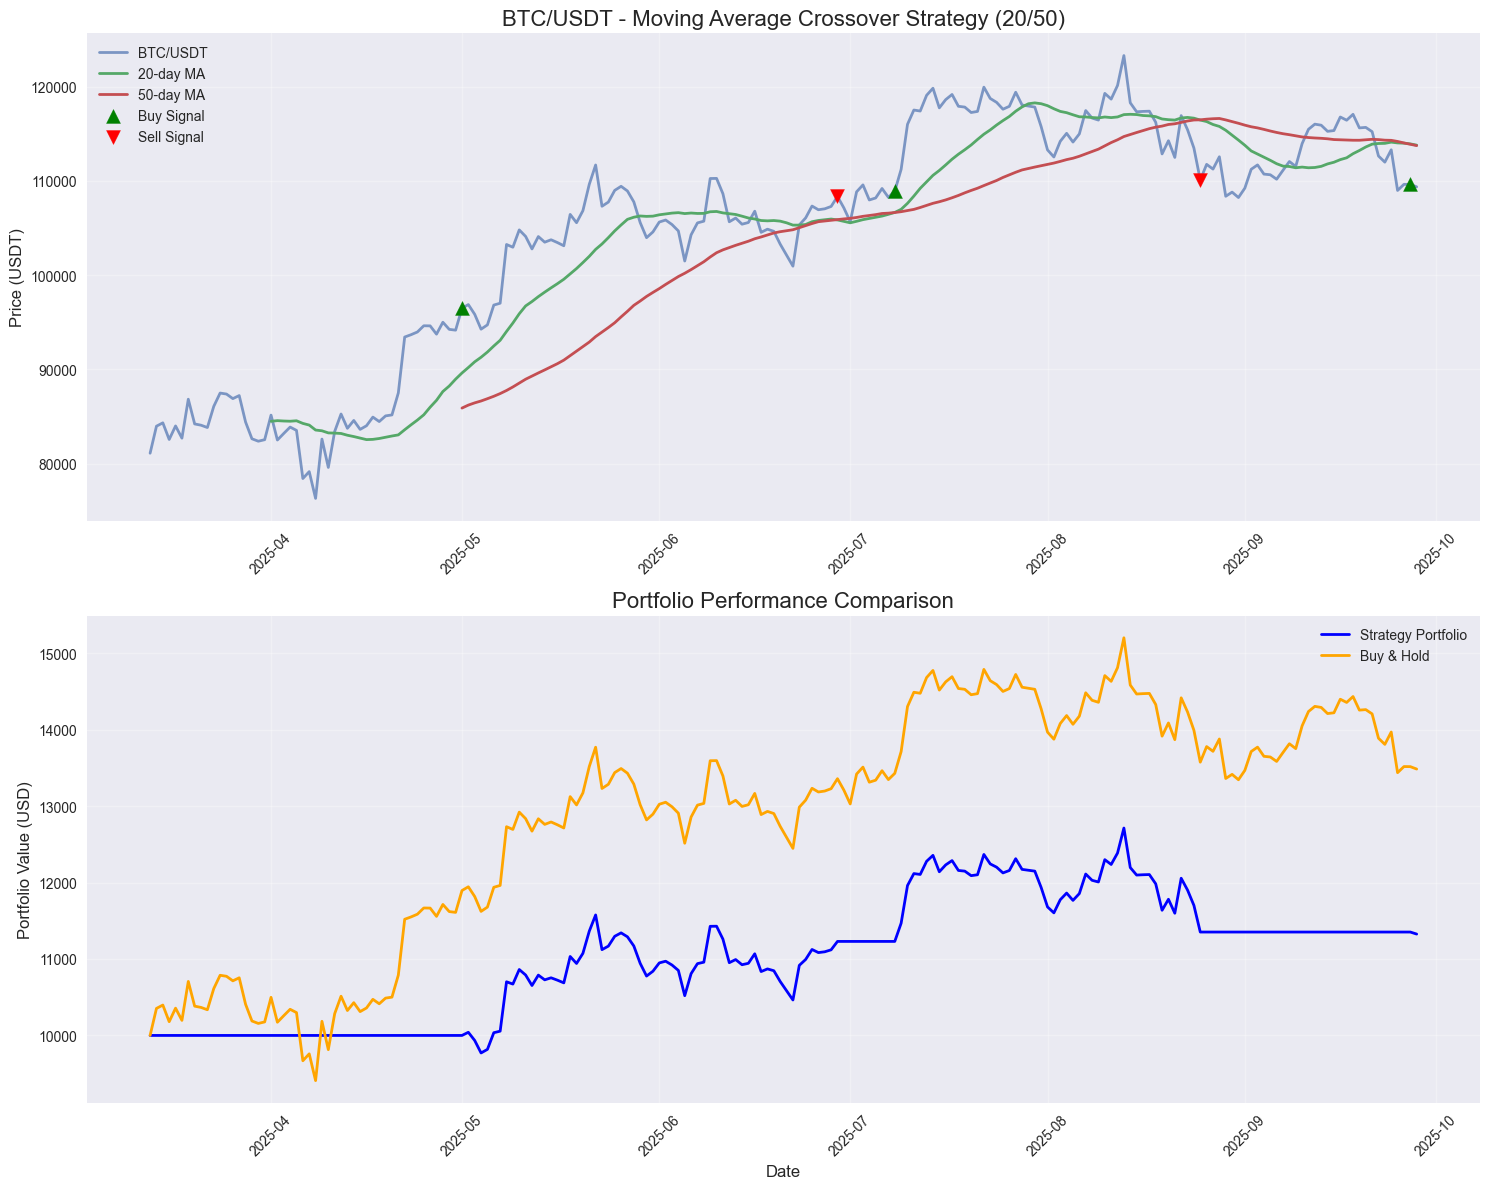


=== SIGNAL SUMMARY ===
Total Buy Signals: 3
Total Sell Signals: 2
Last Buy Signal: 2025-09-27 at $109,635.85
Last Sell Signal: 2025-08-25 at $110,111.98


In [21]:
plot_strategy_results(df_backtest, fast_ma, slow_ma)

In [22]:
def test_different_parameters():
    """
    Test different MA combinations to find optimal parameters
    """
    print("Testing different MA combinations...")
    
    results = []
    fast_ma_range = [10, 15, 20, 25]
    slow_ma_range = [30, 40, 50, 60]
    
    for fast in fast_ma_range:
        for slow in slow_ma_range:
            if fast < slow:  # Fast MA must be shorter than slow MA
                # Calculate strategy for this combination
                df_test = calculate_moving_averages(df, fast, slow)
                df_test = generate_signals(df_test, fast, slow)
                df_test = backtest_strategy(df_test, 10000)
                
                final_value = df_test['portfolio_value'].iloc[-1]
                total_return = ((final_value - 10000) / 10000) * 100
                
                results.append({
                    'Fast_MA': fast,
                    'Slow_MA': slow,
                    'Return_%': total_return,
                    'Final_Value': final_value
                })
    
    # Convert to DataFrame and sort by return
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Return_%', ascending=False)
    
    print("\n=== PARAMETER OPTIMIZATION RESULTS ===")
    print("Top 5 MA combinations:")
    print(results_df.head())
    
    return results_df

In [23]:
optimization_results = test_different_parameters()

Testing different MA combinations...

=== PARAMETER OPTIMIZATION RESULTS ===
Top 5 MA combinations:
    Fast_MA  Slow_MA   Return_%   Final_Value
0        10       30  18.239178  11823.917756
1        10       40  15.472119  11547.211912
9        20       40  14.558908  11455.890807
13       25       40  13.647841  11364.784090
10       20       50  13.258864  11325.886399
